In [1]:
import os
# os.environ['XLA_FLAGS']='--xla_gpu_deterministic_reductions'
# os.environ['TF_CUDNN_DETERMINISTIC']='1'

import jax
import jax.numpy as jnp
from jax import random
import numpy as np
import tensorflow as tf
import logging
import matplotlib.pyplot as plt

In [2]:
from config import ConfigSchema
config = ConfigSchema(
    learning_rate = 0.001,
    momentum = 0.9,
    batch_size = 256,
    num_epochs = 10,
)

In [28]:
%load_ext autoreload
%autoreload 1

%aimport train
%aimport model.model
%aimport data

models = model.model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
weight_tie_pattern = tuple([0,*np.ones(7,dtype=int)])

perceiver = models.Perceiver(
    weight_tie_pattern = weight_tie_pattern,
                                 # depth of net. The shape of the final attention mechanism will be:
                                 #   depth * (cross attention -> self_per_cross_attn * self attention)
    
    num_freq_bands = 4,          # number of freq bands, with original value (2 * K + 1)
    max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
    freq_base = 2,               

    num_latents = 64,            # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 32,             # latent dimension
    
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    cross_head_dim = 64,         # number of dimensions per cross attention head
    
    latent_heads = 8,            # number of heads for latent self attention, 8
    latent_head_dim = 16,        # number of dimensions per latent self attention head
    
    num_classes = 10,            # output number of classes
    attn_dropout = 0.,
    ff_dropout = 0.,
    fourier_encode_data = True,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
    self_per_cross_attn = 2      # number of self attention blocks per cross attention
)

In [30]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

img = random.normal(subkey,(1, 224, 224, 3)) # 1 imagenet image, pixelized

params = perceiver.init(random.PRNGKey(0), img)

out = perceiver.apply(params, img)

out.shape


(1, 10)

In [33]:
train_ds, test_ds = data.get_datasets()

In [38]:
state = train.train_and_evaluate(perceiver, train_ds, test_ds, config, workdir='../')

  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  1, train_loss: 2.0558, train_accuracy: 24.20, test_loss: 1.5426, test_accuracy: 42.97


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  2, train_loss: 0.9880, train_accuracy: 64.81, test_loss: 0.5677, test_accuracy: 80.47


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  3, train_loss: 0.4754, train_accuracy: 84.80, test_loss: 0.4085, test_accuracy: 85.94


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  4, train_loss: 0.3256, train_accuracy: 89.73, test_loss: 0.2624, test_accuracy: 92.19


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  5, train_loss: 0.2733, train_accuracy: 91.56, test_loss: 0.3064, test_accuracy: 90.23


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  6, train_loss: 0.2272, train_accuracy: 92.88, test_loss: 0.1921, test_accuracy: 94.14


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  7, train_loss: 0.1943, train_accuracy: 93.87, test_loss: 0.1624, test_accuracy: 95.31


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  8, train_loss: 0.1722, train_accuracy: 94.55, test_loss: 0.1918, test_accuracy: 94.53


  0%|          | 0/234 [00:00<?, ?it/s]

epoch:  9, train_loss: 0.1542, train_accuracy: 95.09, test_loss: 0.1215, test_accuracy: 96.09


  0%|          | 0/234 [00:00<?, ?it/s]

epoch: 10, train_loss: 0.1354, train_accuracy: 95.73, test_loss: 0.1455, test_accuracy: 96.09


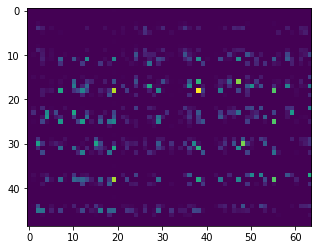

In [31]:
x = train_ds['image'][0]

f = model.features(state.params,[x])
f = f.reshape((49,-1))

fig,ax = plt.subplots(figsize=(15,4))
ax.imshow(f)